## Eksperimen dengan Stock Market data
- 13520116 / Mahesa Lizardy
- 13520146 / Bryan Amirul Husna

In [1]:
# import libraries
from src.Model import Model
from src.Dense import Dense
from src.LSTM import LSTM
from src.Scaler import Scaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load and tampilkan sebagian data
df_train = pd.read_csv('./Dataset/StockMarket/Train_stock_market.csv')
df_test = pd.read_csv('./Dataset/StockMarket/Test_stock_market.csv')
df_train.index = pd.to_datetime(df_train['Date'], format='%d-%m-%Y')
df_test.index = pd.to_datetime(df_test['Date'], format='%Y-%m-%d')

df_train

,Date,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,,
1984-09-07,07-09-1984,5.25,5.500,7900,5.50,5.25,5.25
1984-09-10,10-09-1984,5.25,5.250,600,5.50,5.25,5.25
1984-09-11,11-09-1984,5.25,5.250,3500,5.50,5.25,5.25
1984-09-12,12-09-1984,5.50,5.500,700,5.50,5.50,5.50
1984-09-13,13-09-1984,5.00,5.500,1700,5.50,5.00,5.00
...,...,...,...,...,...,...,...
2022-12-06,06-12-2022,3.76,3.800,22400,3.99,3.81,3.81
2022-12-07,07-12-2022,3.68,3.750,18000,3.85,3.74,3.74
2022-12-08,08-12-2022,3.80,3.820,51600,4.00,3.85,3.85


In [3]:
# Fungsi untuk preprocessing data timestep

# Fungsi mengubah pandas DataFrame ke numpy array, hanya mengambil kolom-kolom tertentu (parameter columns)
def df_to_np(df, columns):
  return df[columns].to_numpy()

# Fungsi membuat sequences, data masukan bertipe numpy array
def create_sequences(data, seq_length):
  sequences = []
  targets = []
  data_len = len(data)
  for i in range(data_len - seq_length):
    seq_end = i + seq_length
    seq_x = data[i:seq_end]
    seq_y = data[seq_end]
    sequences.append(seq_x)
    targets.append(seq_y)

  return np.array(sequences), np.array(targets)

In [4]:
# Preprocess data

# Mengambil 5 kolom numerik yang ingin diprediksi
columns = ['Low', 'Open', 'Volume', 'High', 'Close']
train_np = df_to_np(df_train, columns)
test_np = df_to_np(df_test, columns)

# Scale menjadi antara 0 sampai 1
scaler = Scaler()
scaler.fit(train_np)
train_np_scaled = scaler.transform(train_np)
test_np_scaled = scaler.transform(test_np)

In [5]:
# Load model
# Memuat model dengan weight yang sudah tersimpan
model = Model.load_model('./Models/model_4_parameters.json')

# Model tersebut dapat dibuat manual dengan kode:
# model = Model()
# model.add(LSTM(num_units=64, input_shape=(num_timesteps, num_features)))
# model.add(Dense(num_units=5, activation_function="linear"))

model.summary()

Model: "sequential"
_______________________________________________________
Layer (type)        Output Shape        Param #        
lstm (LSTM)         (None, 64)          17920          
dense (Dense)       (None, 5)           325            
Total params: 18245


=== TRAIN DATA ===
===== 5-TIMESTEP =====
RMSE per column: [0.01427878 0.01033523 0.01152618 0.01326391 0.01517672]
RMSE total: 0.06458081355209215
RMSE average: 0.01291616271041843


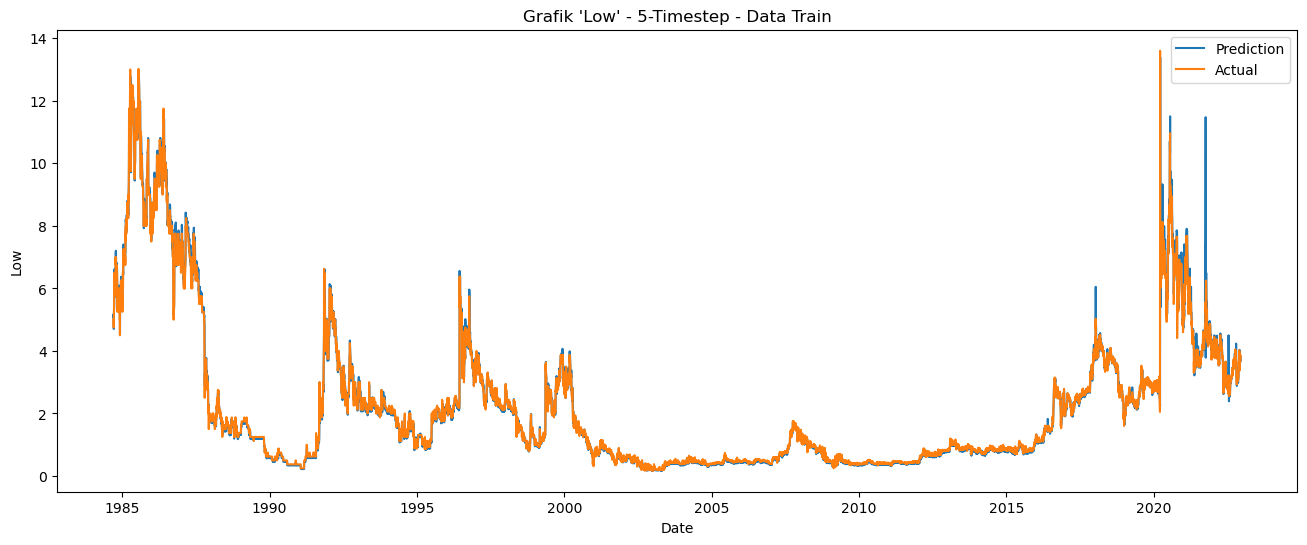

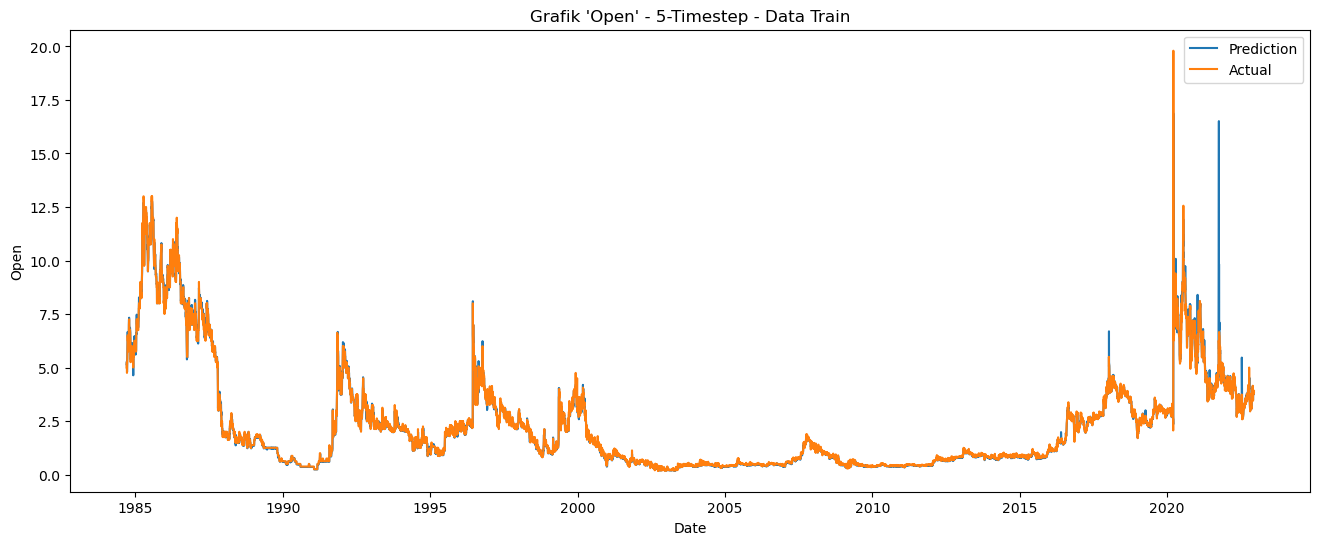

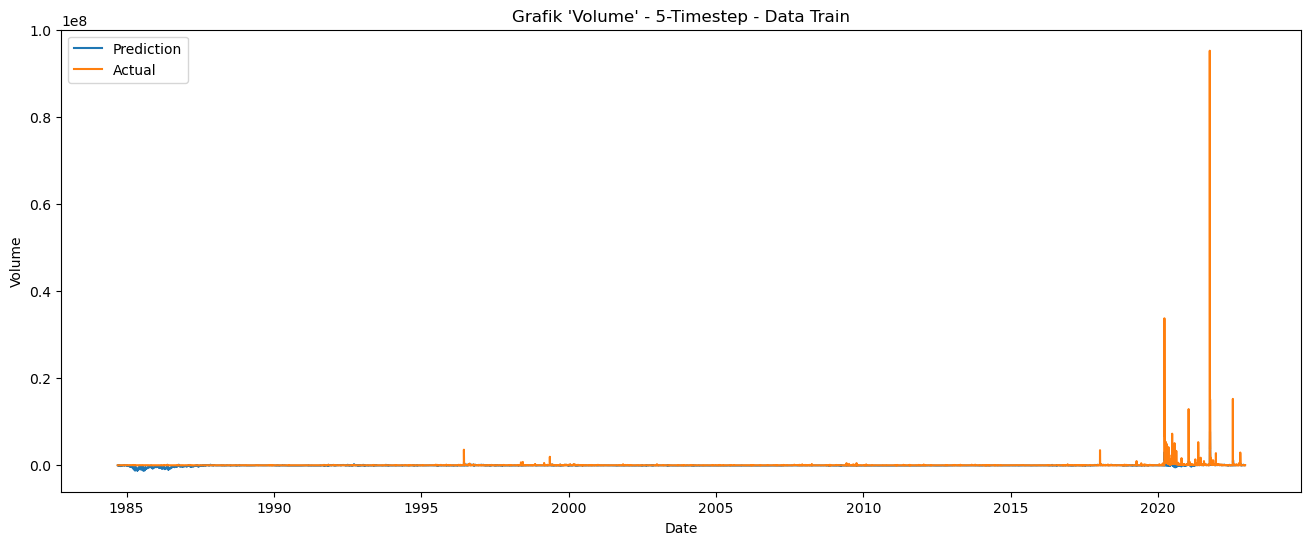

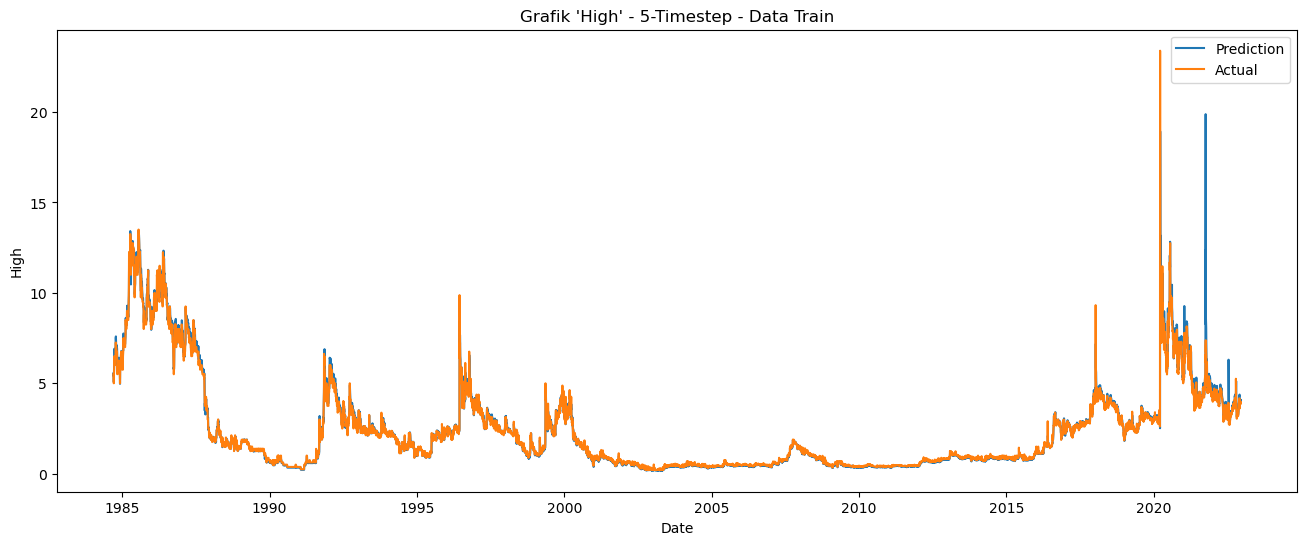

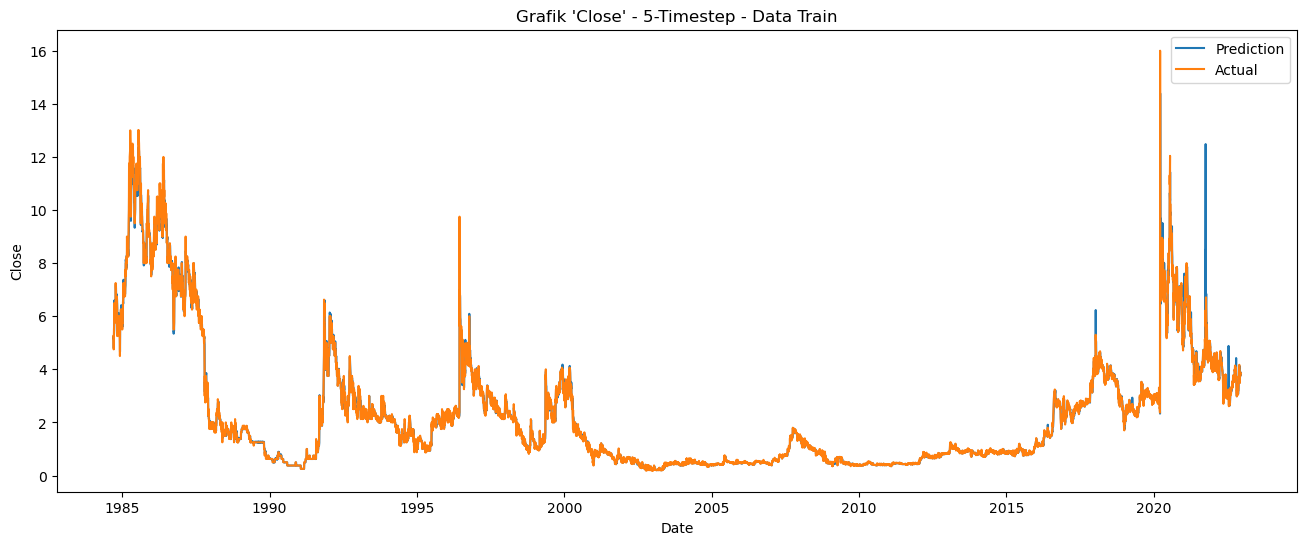

===== 15-TIMESTEP =====
RMSE per column: [0.01706401 0.01171781 0.01223174 0.01706606 0.01653001]
RMSE total: 0.07460963378563762
RMSE average: 0.014921926757127524


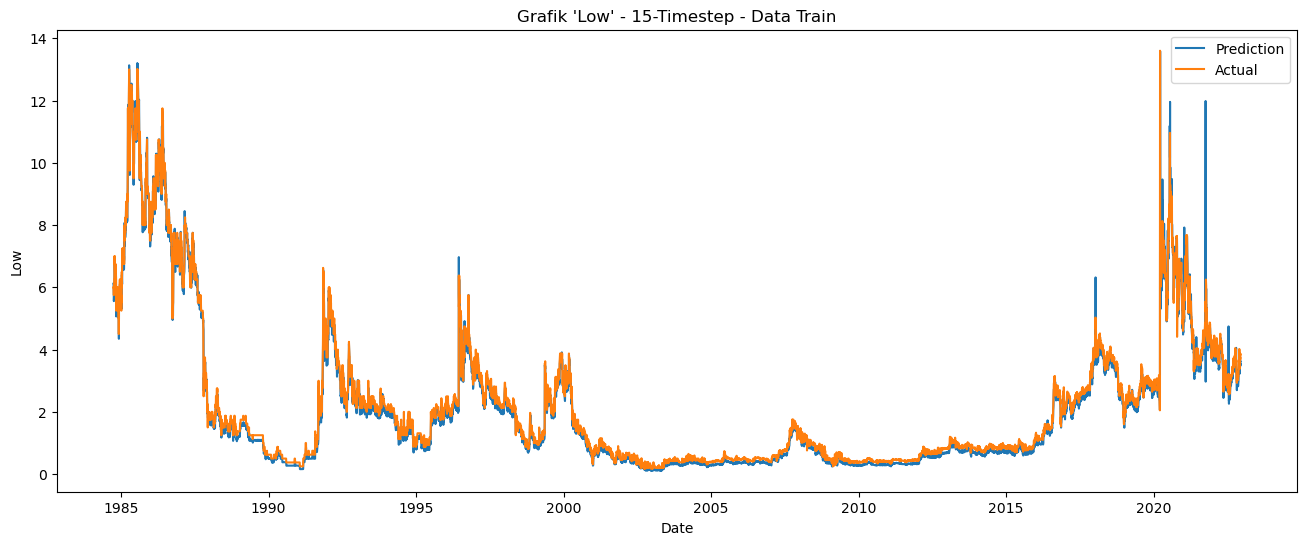

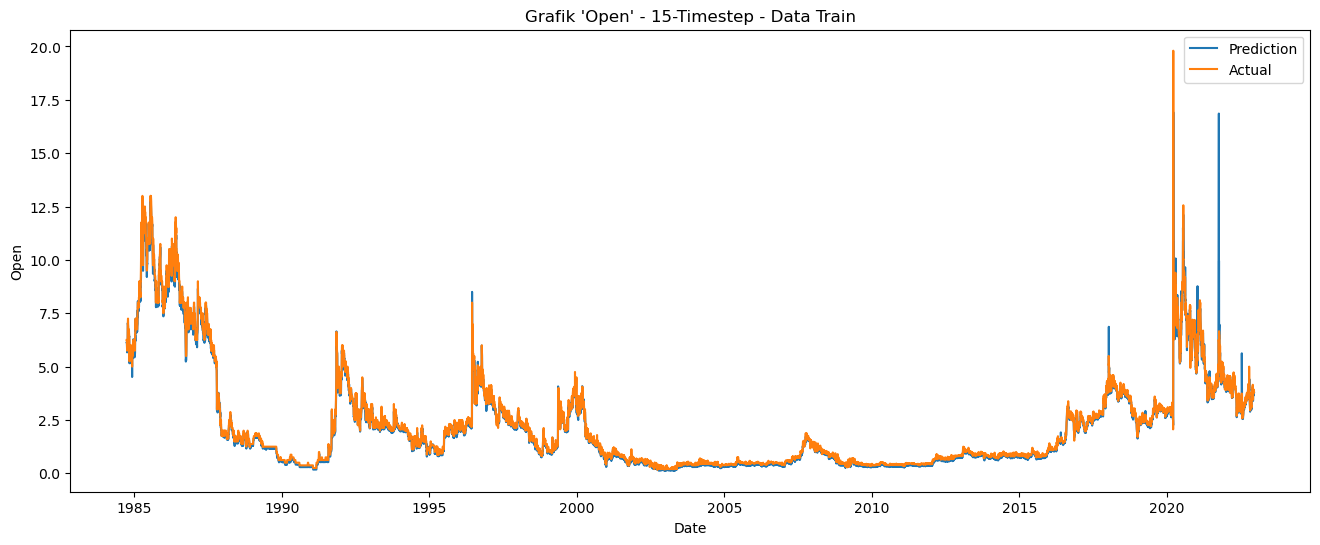

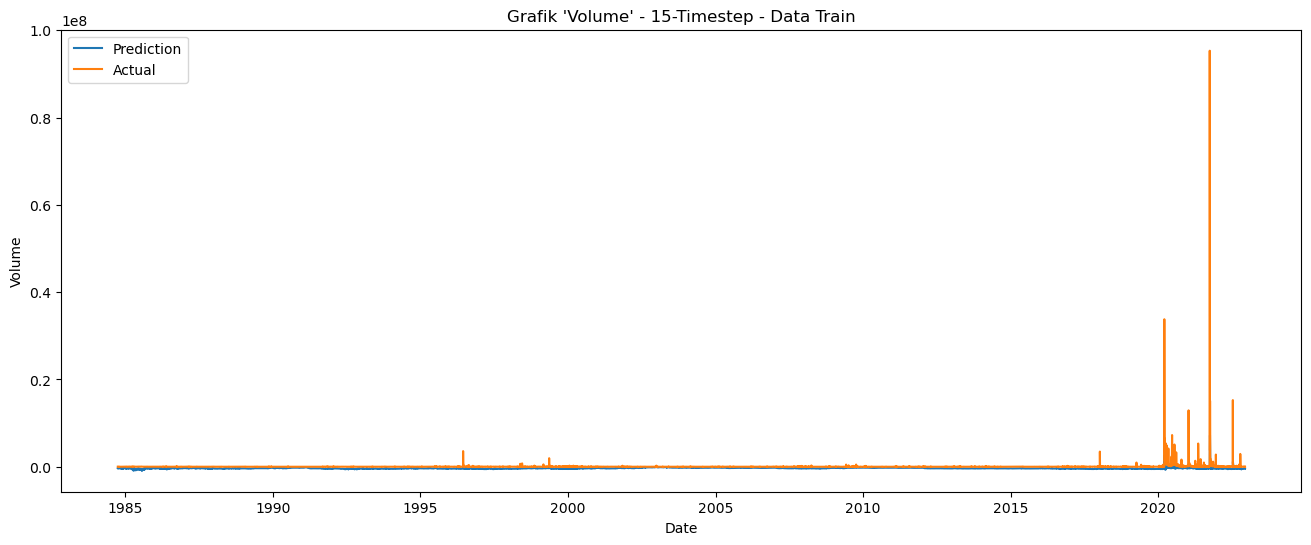

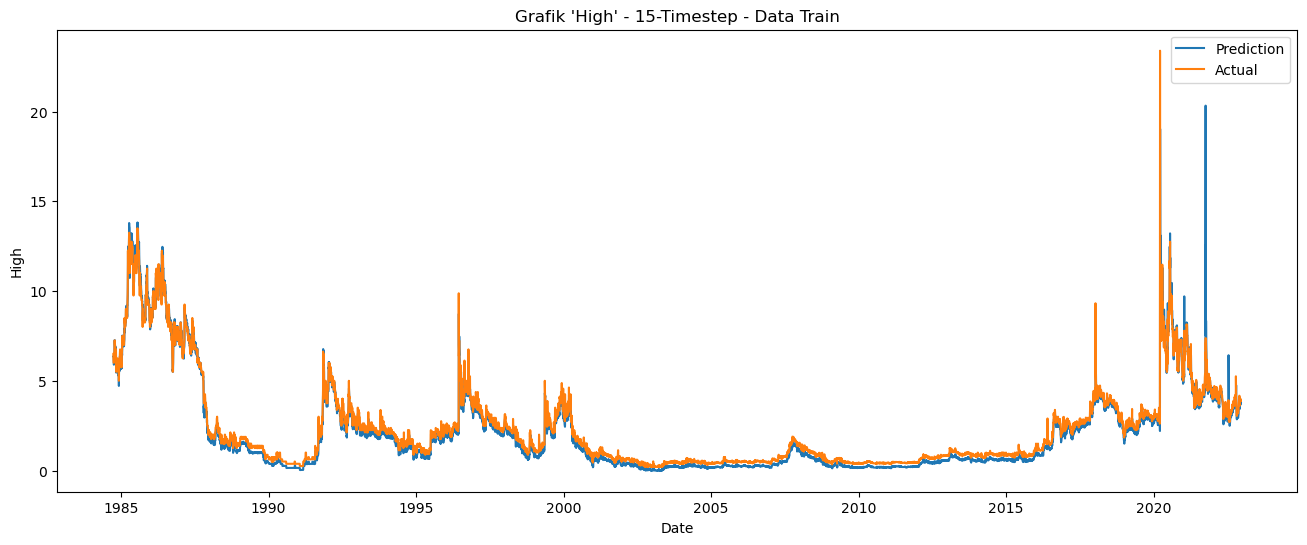

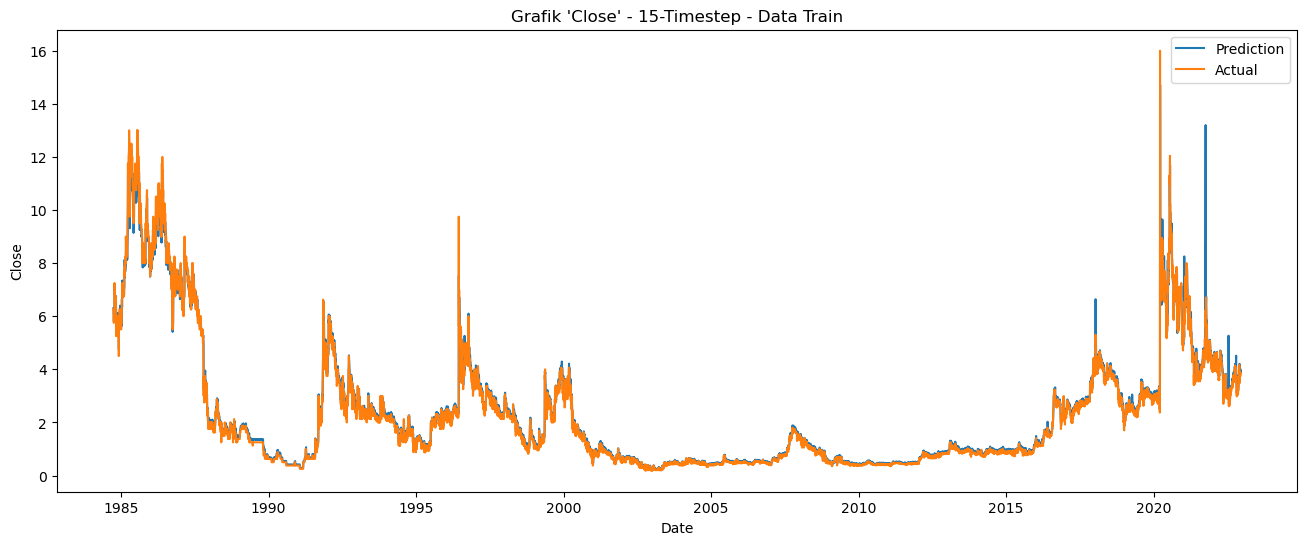

===== 25-TIMESTEP =====
RMSE per column: [0.01731334 0.01200688 0.01237262 0.01767015 0.01694274]
RMSE total: 0.07630572501856067
RMSE average: 0.015261145003712135


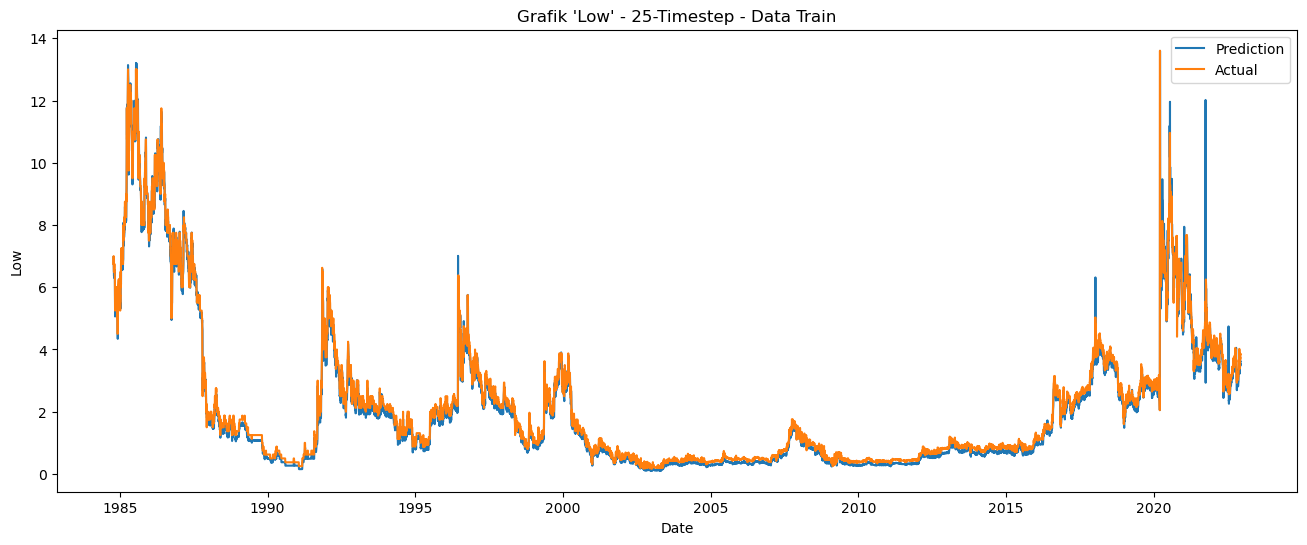

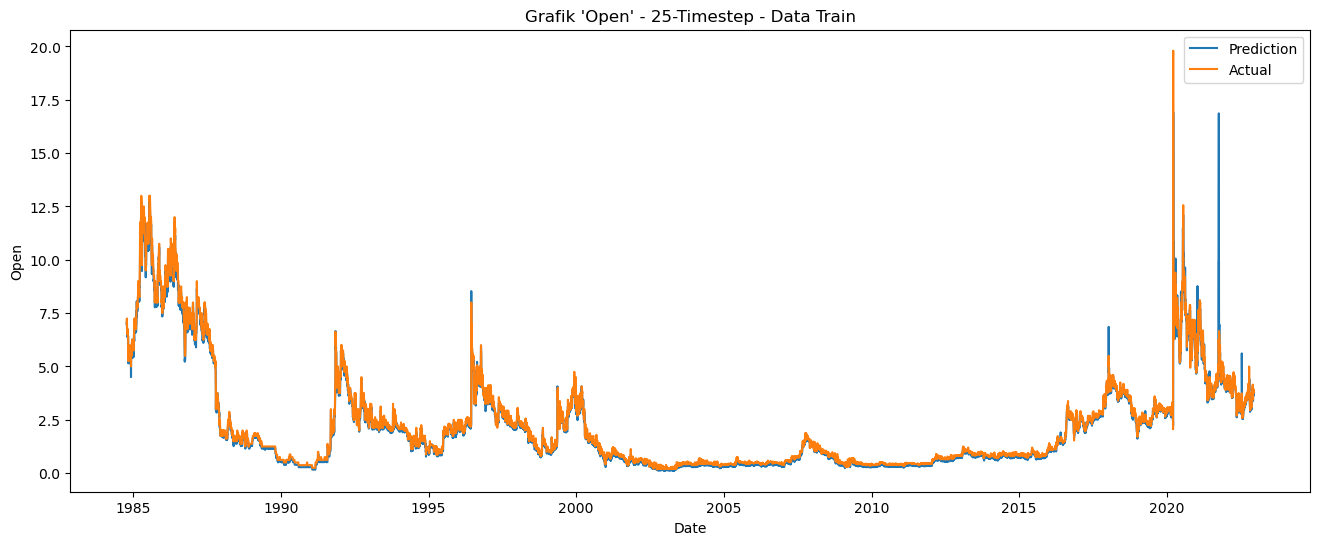

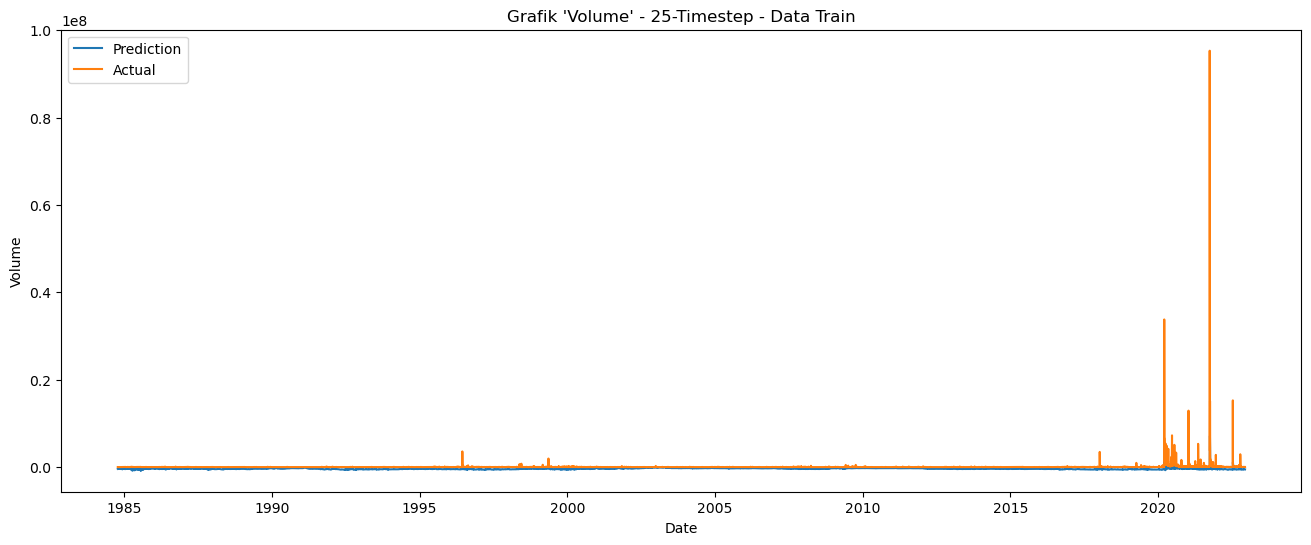

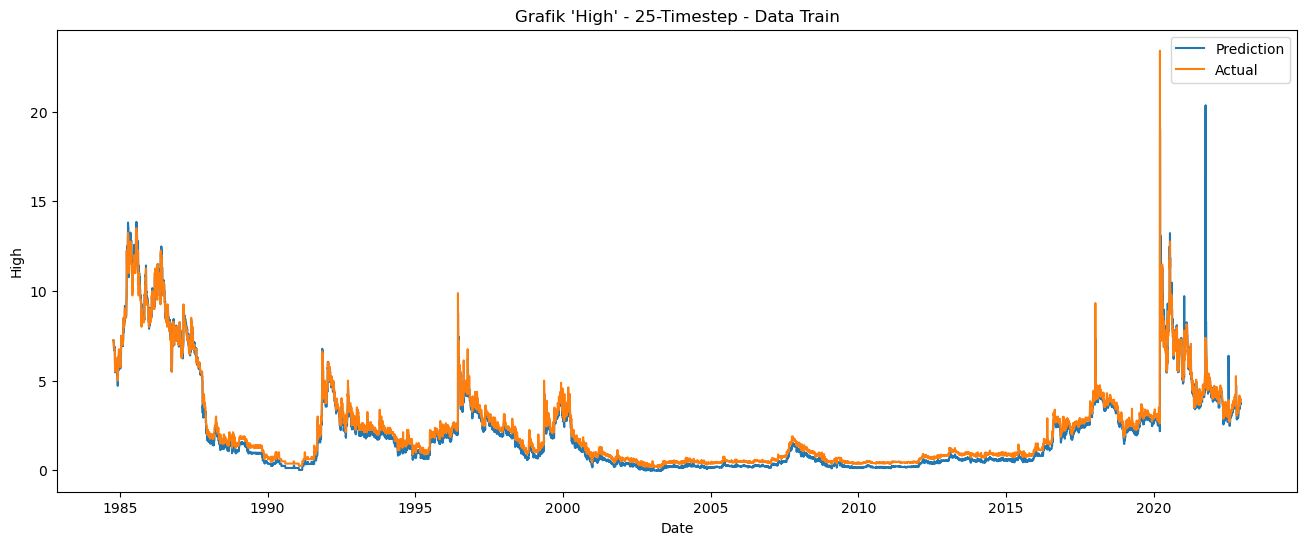

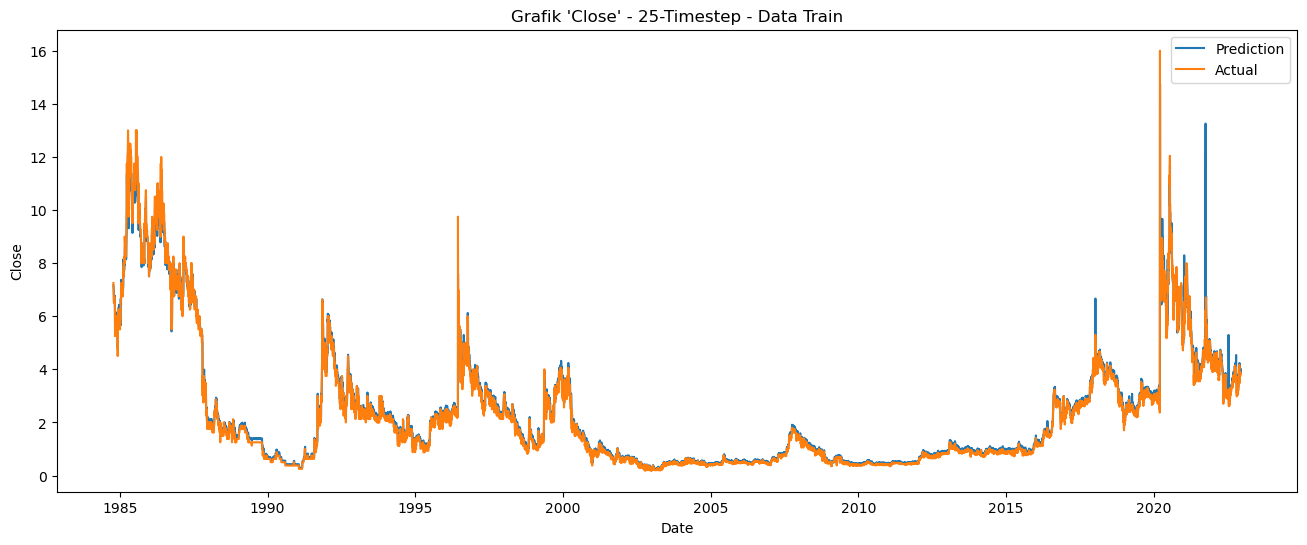

In [6]:
# Eksperimen pada data latih
BASE_SEQ = 5
SEQ_INC = 10

print("=== TRAIN DATA ===")
for i in range(3):
    seq = BASE_SEQ + i * SEQ_INC
    print(f"===== {seq}-TIMESTEP =====")

    # Membuat sequence training
    # Tidak dipecah menjadi training dan validation karena tidak ada tahap backpropagation (training)
    X_train, y_train = create_sequences(train_np_scaled, seq)

    # Melakukan prediksi
    predictions = model.predict(X_train)

    # Evaluation
    rmse = ((predictions - y_train) ** 2).mean(axis=0) ** 0.5
    print("RMSE per column:", rmse)
    print("RMSE total:", rmse.sum())
    print("RMSE average:", rmse.mean())

    # Transformasi data
    # Mengekstrak tanggal rentang prediksi
    date_seq = create_sequences(df_to_np(df_train, ['Date']), seq)
    date = date_seq[1][:, 0]

    # Inverse skala, yaitu mengubah dari 0-1 menjadi rentang semula
    y_train_inversed = scaler.inverse_transform(y_train)
    predictions_inversed = scaler.inverse_transform(predictions)

    # Membangun DataFrame actual dan results (predictions)
    actuals_dict = { 'Date': date }
    results_dict = { 'Date': date }
    for i in range(len(columns)):
        actuals_dict[columns[i]] = y_train_inversed[:, i]
        results_dict[columns[i]] = predictions_inversed[:, i]
    actuals = pd.DataFrame(data=actuals_dict)
    results = pd.DataFrame(data=results_dict)
    actuals.index = pd.to_datetime(actuals['Date'], format='%d-%m-%Y')
    results.index = pd.to_datetime(results['Date'], format='%d-%m-%Y')

    # Visualisasi Prediction vs Actual, grafik ditampilkan per kolom data
    for col in columns:
        plt.figure(figsize=(16,6))
        plt.title(f"Grafik '{col}' - {seq}-Timestep - Data Train")
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.plot(results[col])
        plt.plot(actuals[col])
        plt.legend(['Prediction', 'Actual'])
        plt.show()

=== TEST DATA ===
===== 5-TIMESTEP =====
RMSE per column: [0.00747945 0.00259604 0.00050748 0.00429483 0.00706829]
RMSE total: 0.021946091247256078
RMSE average: 0.004389218249451215


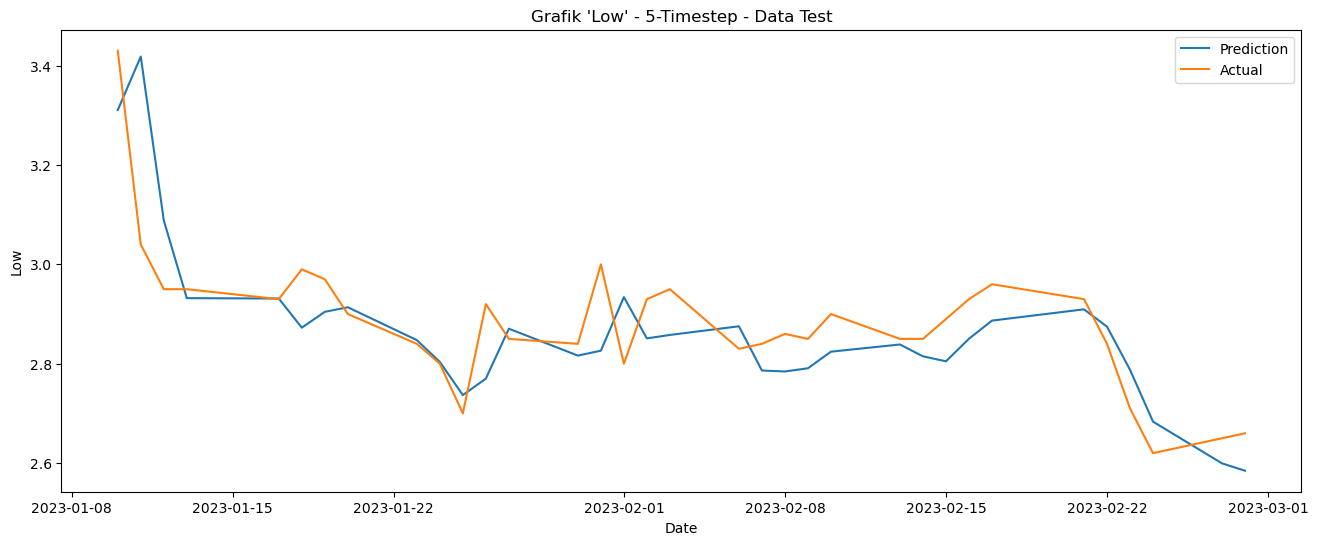

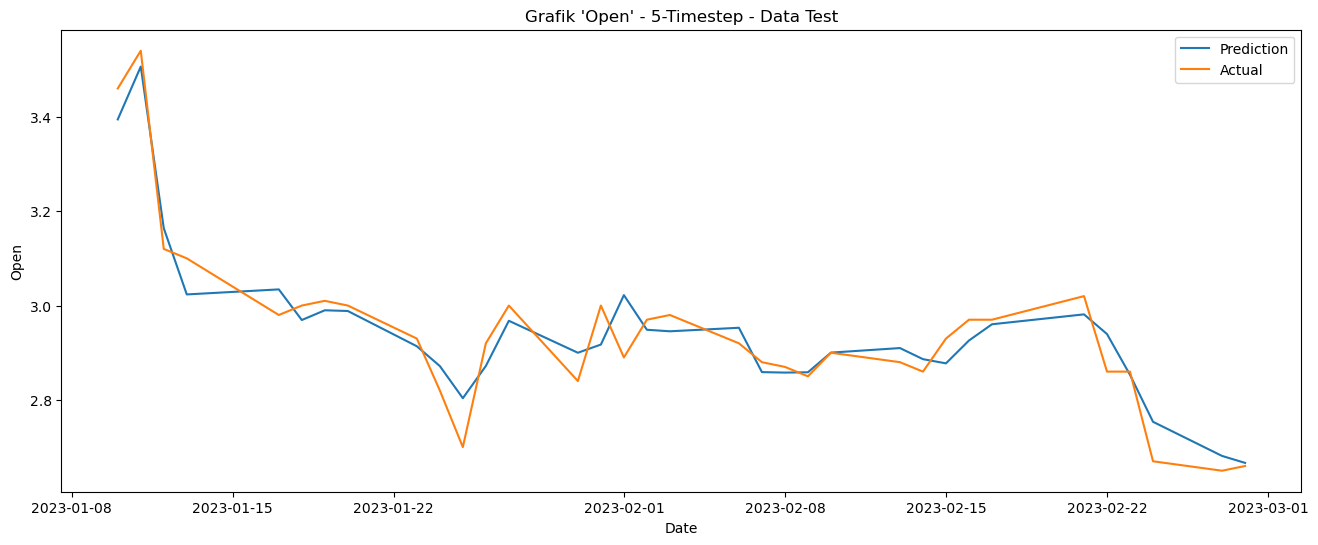

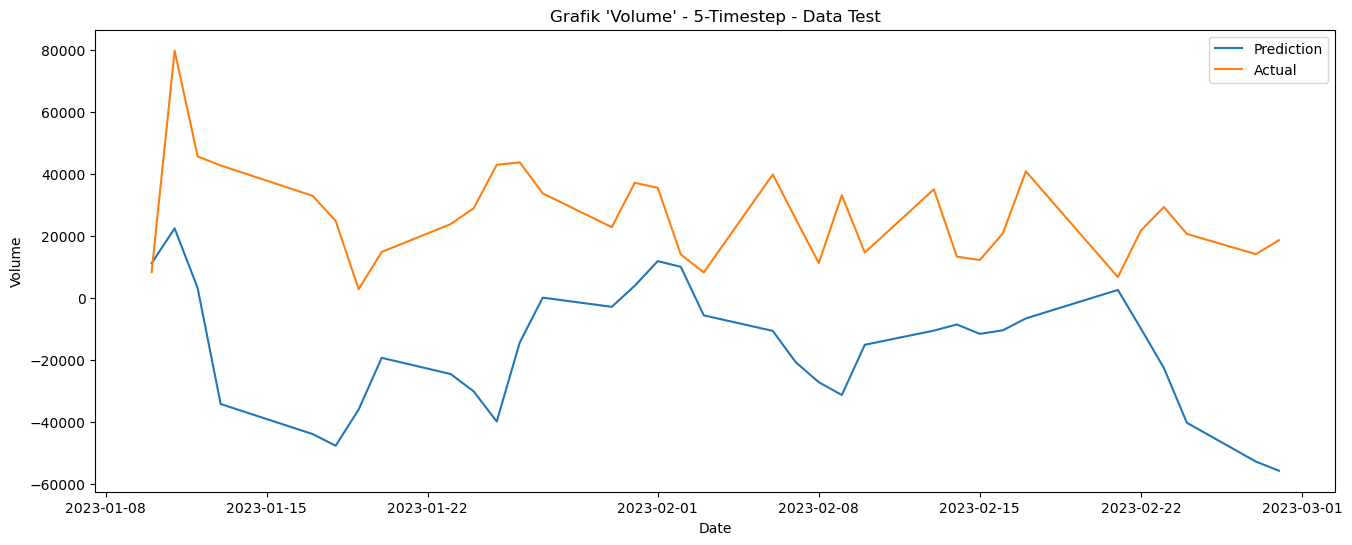

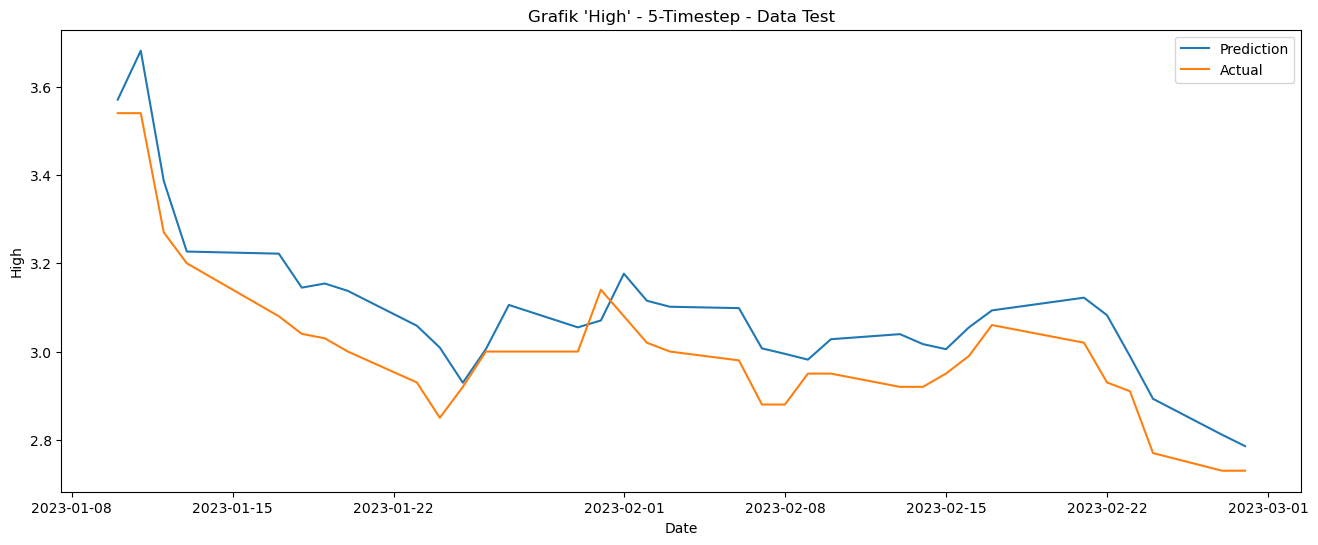

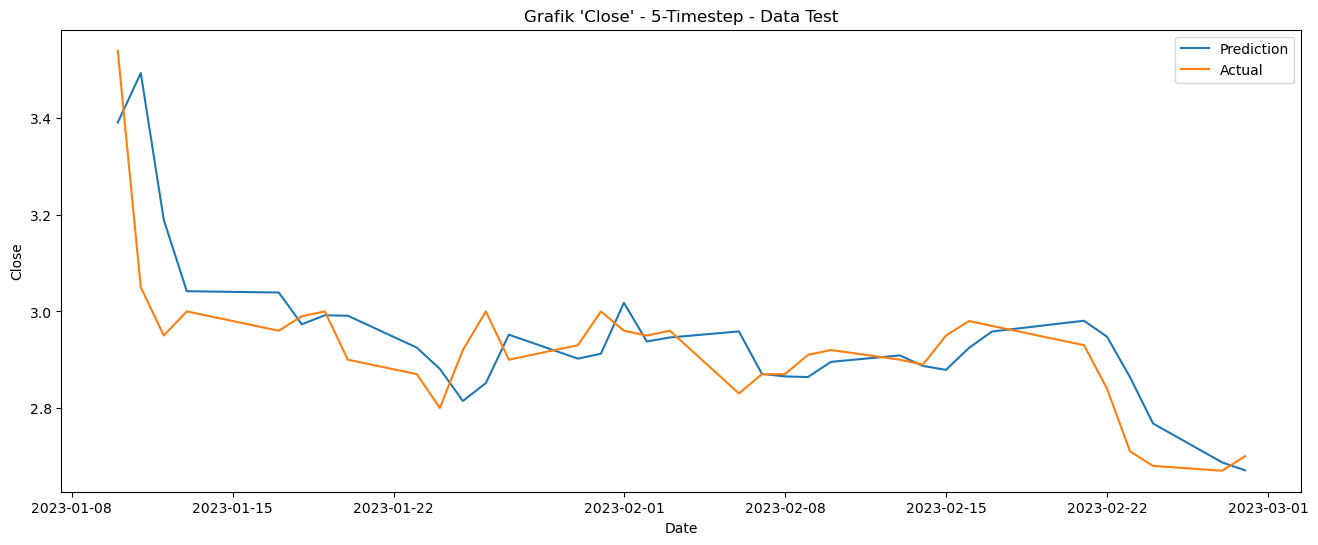

===== 15-TIMESTEP =====
RMSE per column: [0.01458627 0.00445977 0.00564656 0.01014441 0.00860391]
RMSE total: 0.04344092727442604
RMSE average: 0.008688185454885209


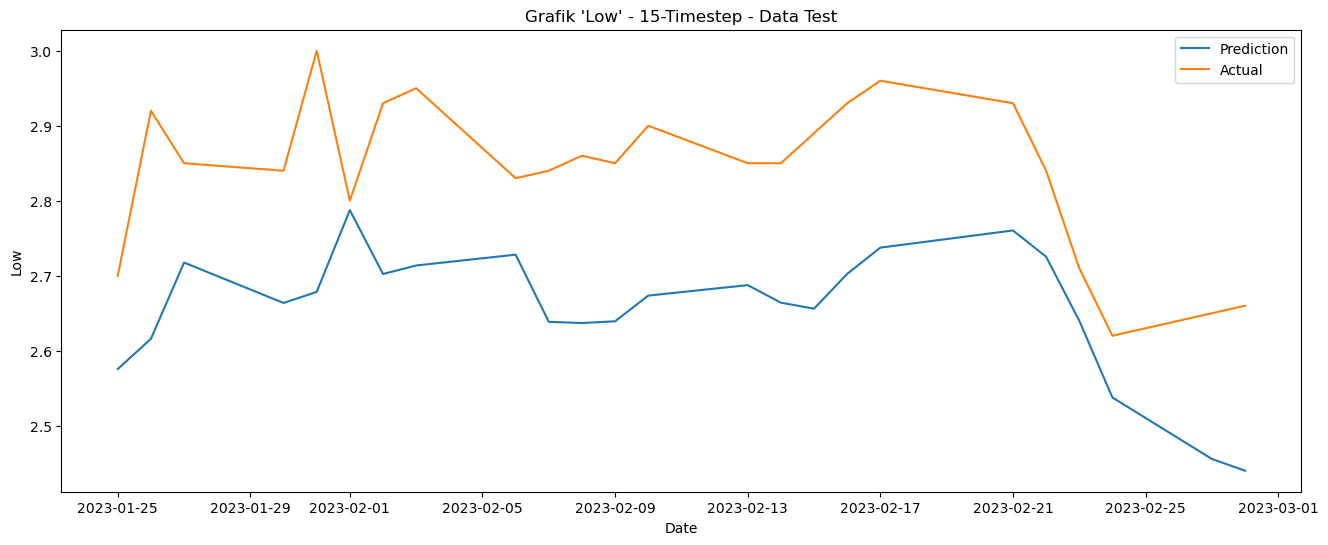

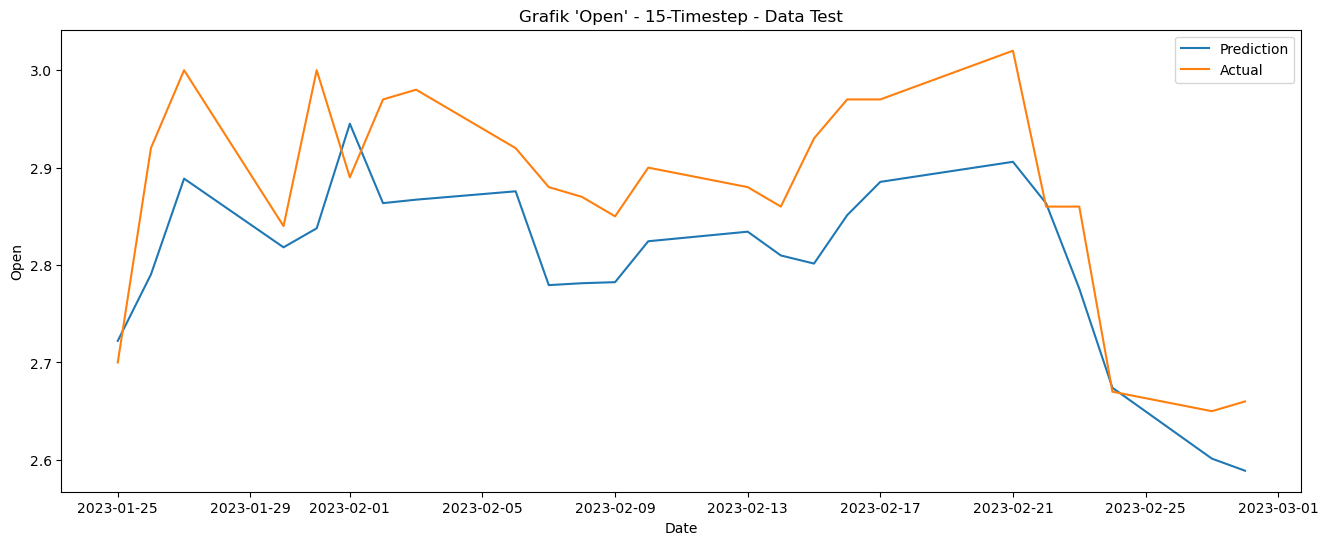

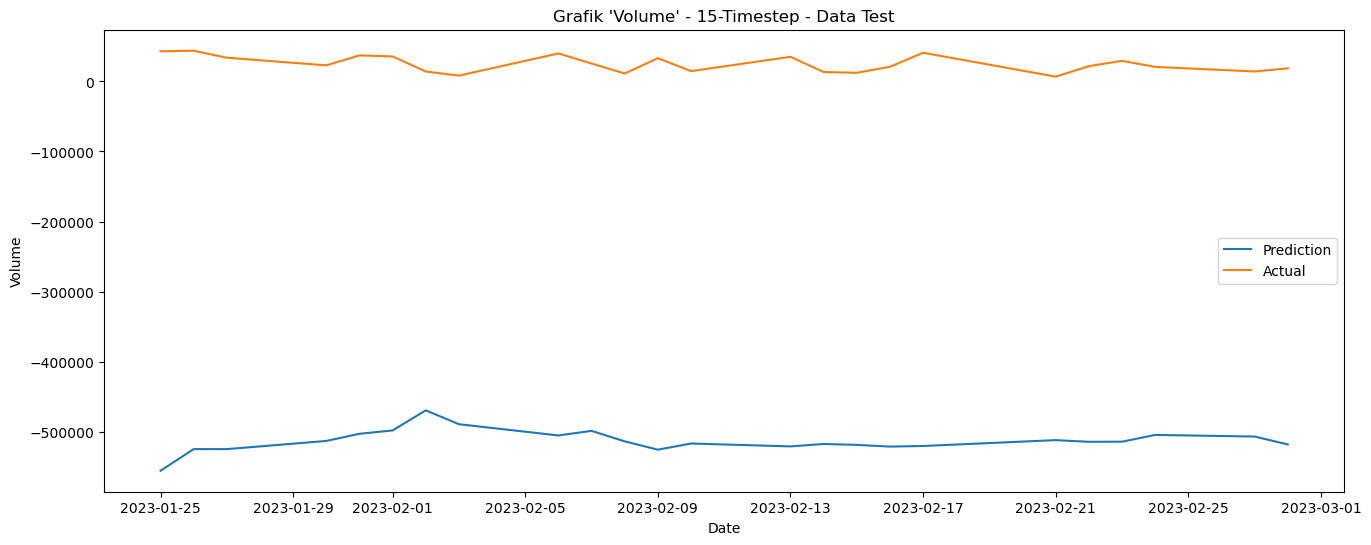

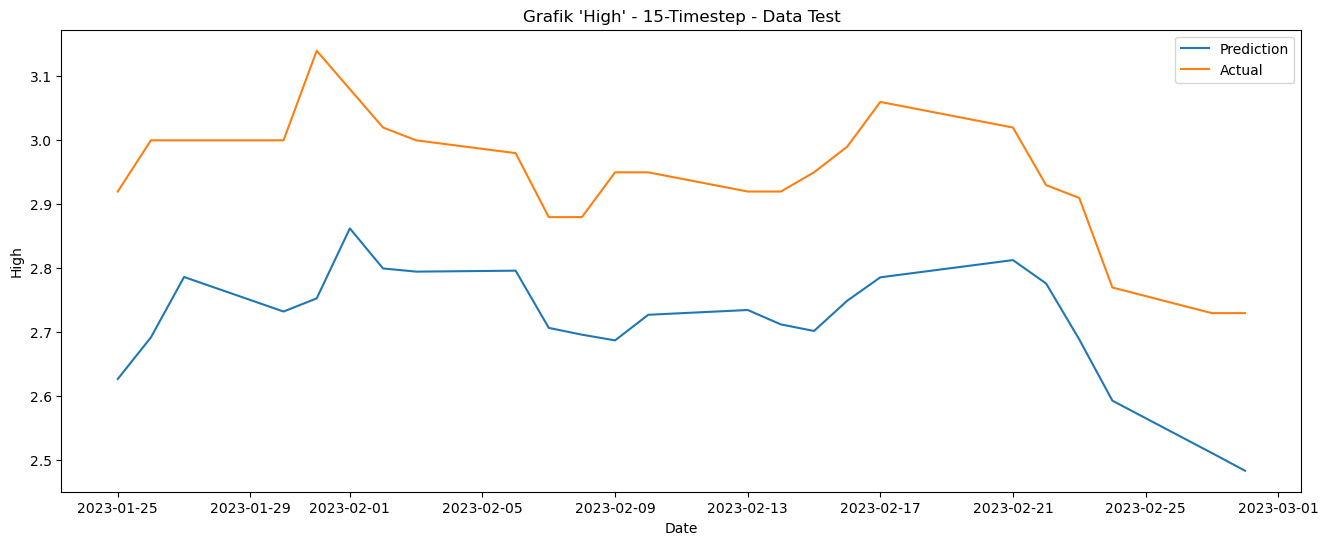

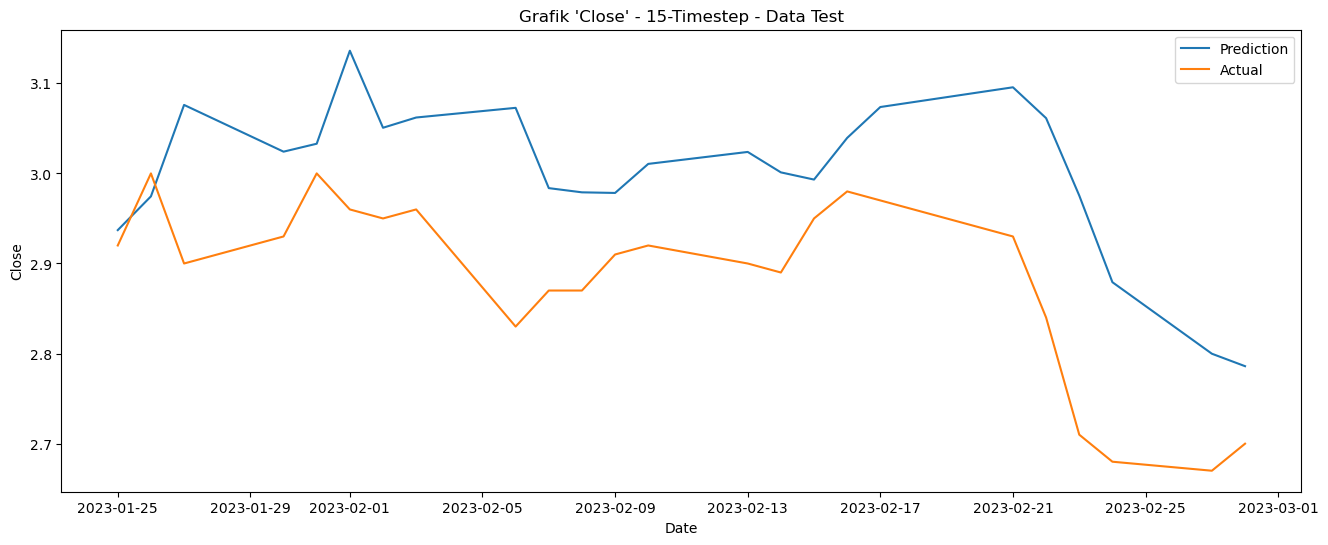

===== 25-TIMESTEP =====
RMSE per column: [0.01455513 0.00467468 0.00608252 0.01057692 0.01048233]
RMSE total: 0.04637158739900287
RMSE average: 0.009274317479800575


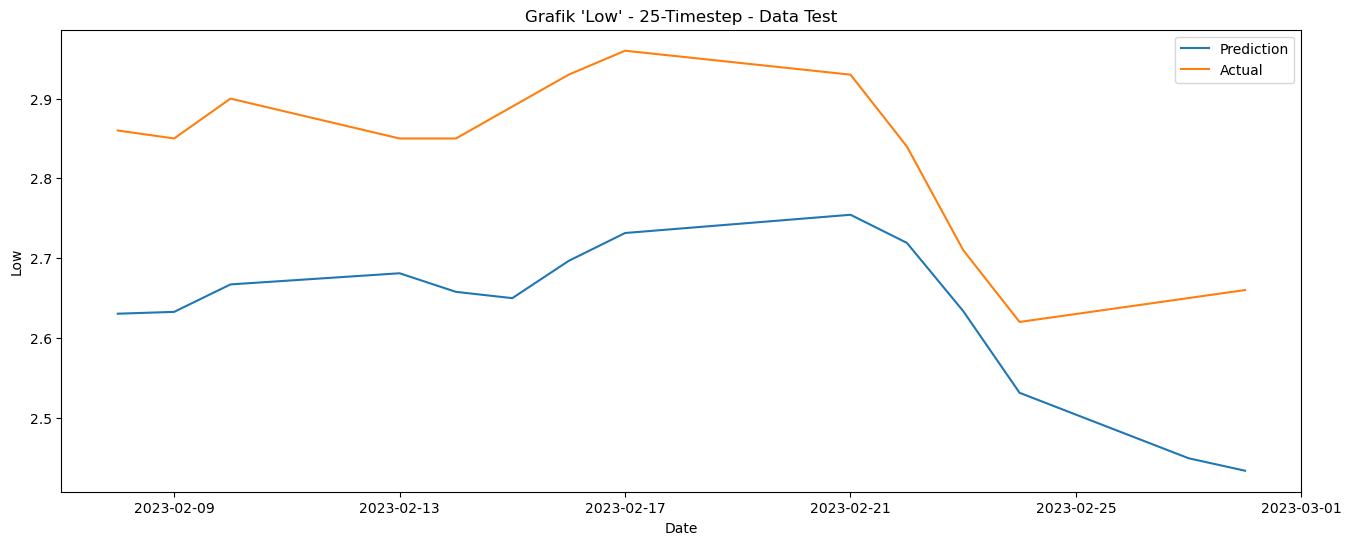

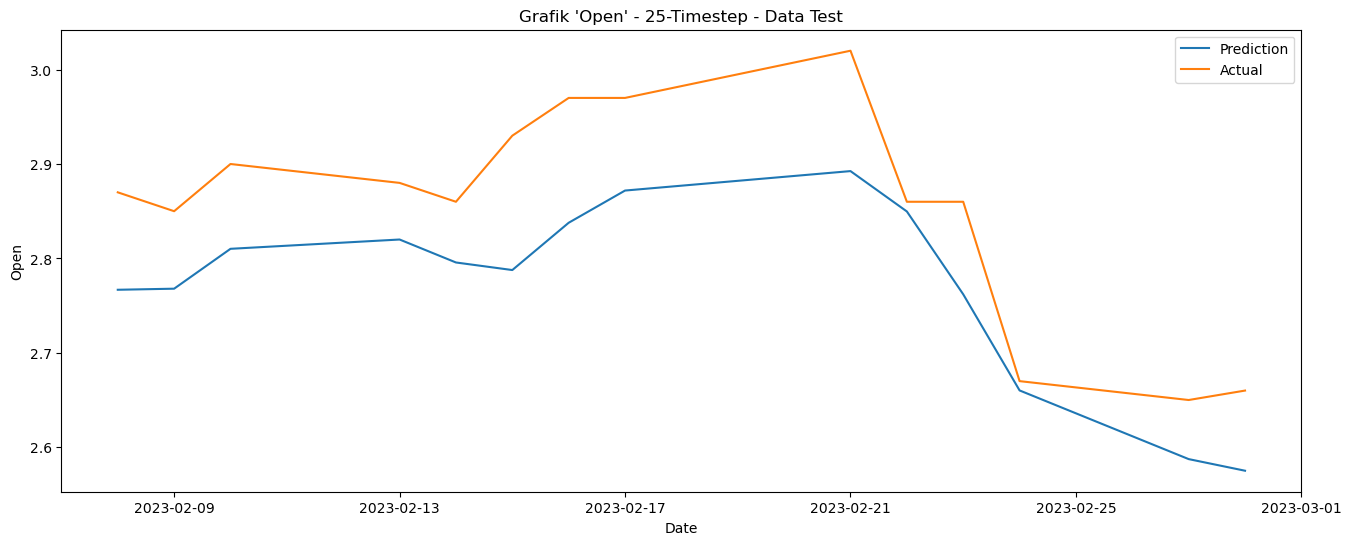

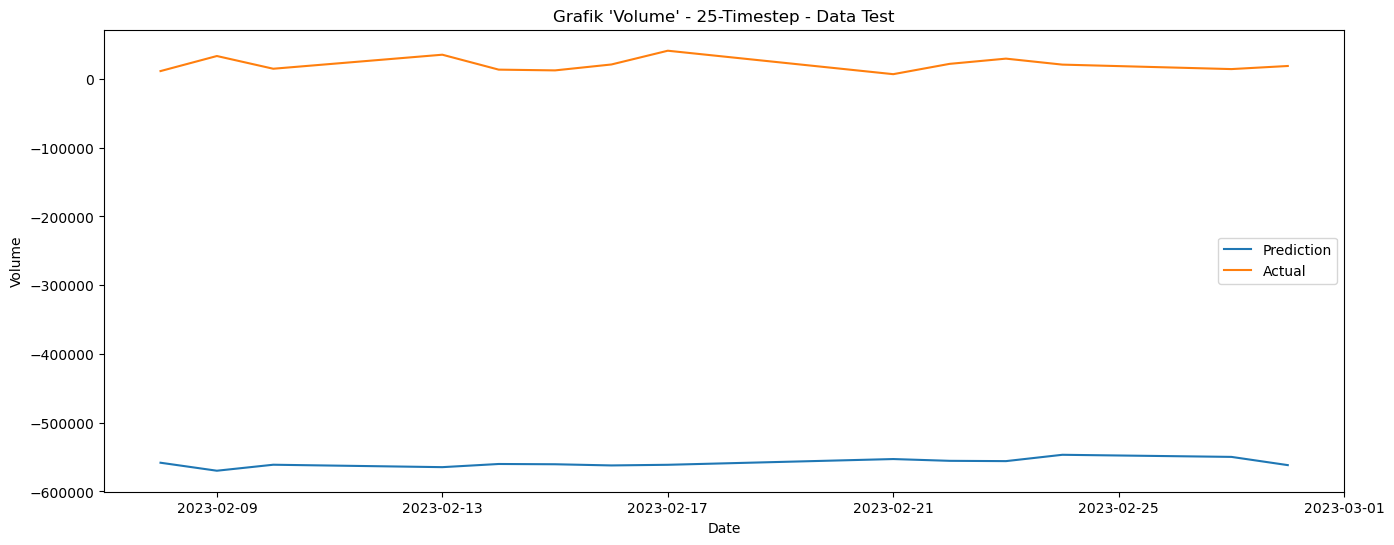

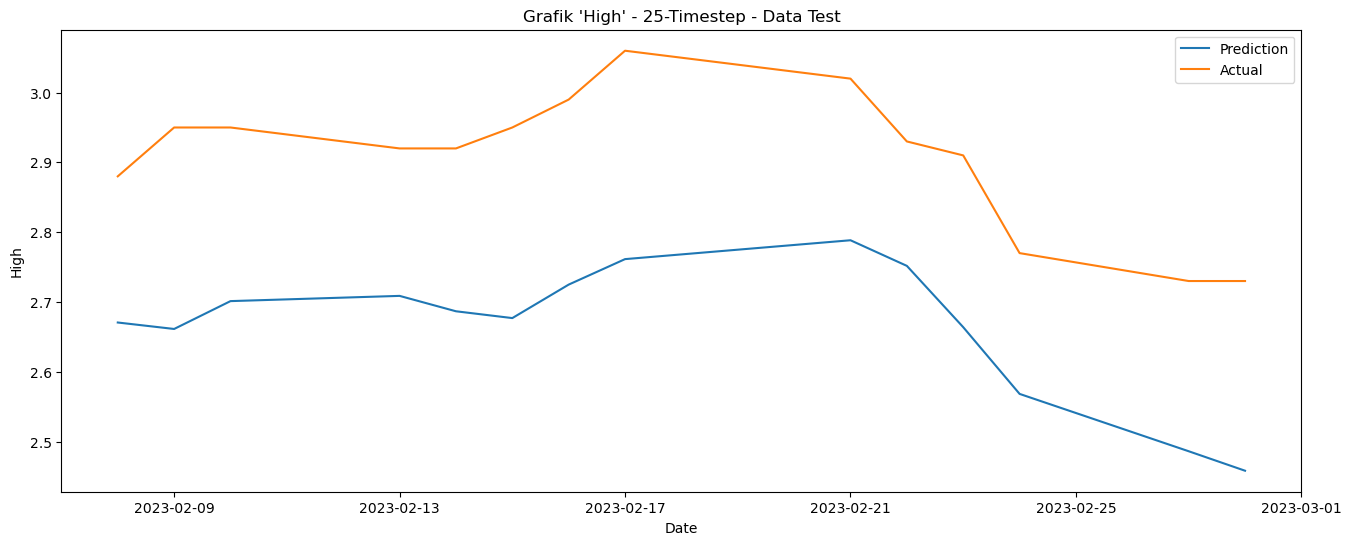

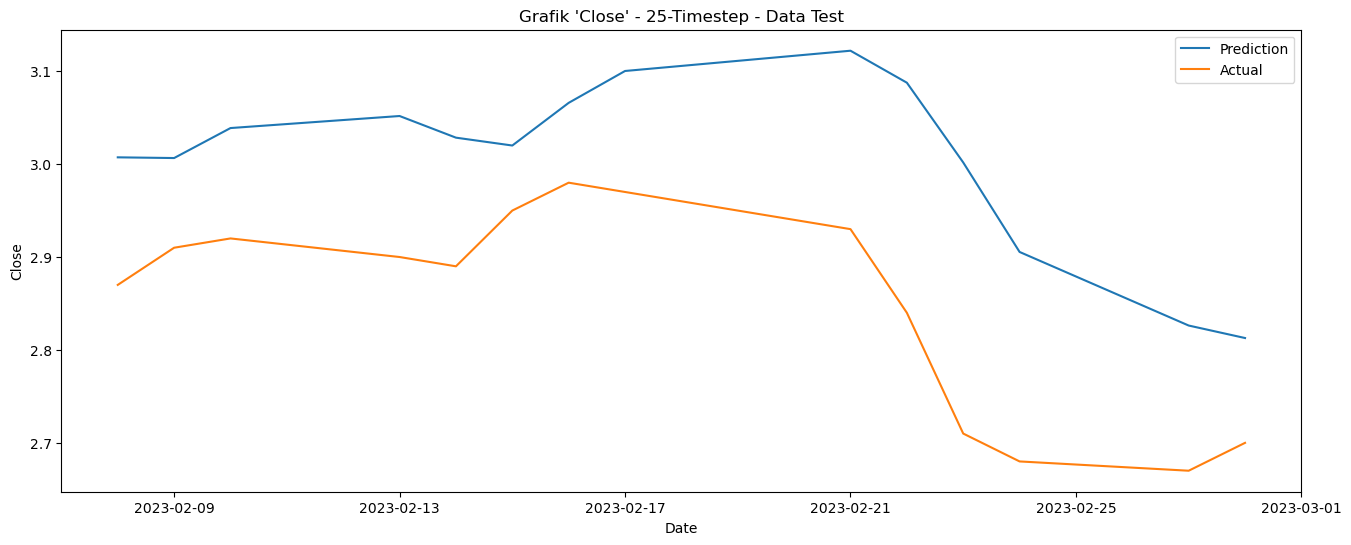

In [7]:
# Eksperimen pada data uji

print("=== TEST DATA ===")
for i in range(3):
    seq = BASE_SEQ + i * SEQ_INC
    print(f"===== {seq}-TIMESTEP =====")

    # Membuat sequence test
    X_test, y_test = create_sequences(test_np_scaled, seq)

    # Melakukan prediksi
    predictions = model.predict(X_test)

    # Evaluation
    rmse = ((predictions - y_test) ** 2).mean(axis=0) ** 0.5
    print("RMSE per column:", rmse)
    print("RMSE total:", rmse.sum())
    print("RMSE average:", rmse.mean())

    # Transformasi data
    # Mengekstrak tanggal rentang prediksi
    date_seq = create_sequences(df_to_np(df_test, ['Date']), seq)
    date = date_seq[1][:, 0]

    # Inverse skala, yaitu mengubah dari 0-1 menjadi rentang semula
    y_test_inversed = scaler.inverse_transform(y_test)
    predictions_inversed = scaler.inverse_transform(predictions)

    # Membangun DataFrame actual dan results (predictions)
    actuals_dict = { 'Date': date }
    results_dict = { 'Date': date }
    for i in range(len(columns)):
        actuals_dict[columns[i]] = y_test_inversed[:, i]
        results_dict[columns[i]] = predictions_inversed[:, i]
    actuals = pd.DataFrame(data=actuals_dict)
    results = pd.DataFrame(data=results_dict)
    actuals.index = pd.to_datetime(actuals['Date'], format='%Y-%m-%d')
    results.index = pd.to_datetime(results['Date'], format='%Y-%m-%d')

    # Visualisasi Prediction vs Actual, grafik ditampilkan per kolom data
    for col in columns:
        plt.figure(figsize=(16,6))
        plt.title(f"Grafik '{col}' - {seq}-Timestep - Data Test")
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.plot(results[col])
        plt.plot(actuals[col])
        plt.legend(['Prediction', 'Actual'])
        plt.show()